# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

Upload the `test.csv` and `training.csv` files that you can download from campus virtual.

In [ ]:
from google.colab import drive
drive.mount('/content/driveMyDrive/')

Drive already mounted at /content/driveMyDrive/; to attempt to forcibly remount, call drive.mount("/content/driveMyDrive/", force_remount=True).


In [ ]:
# loading data

FTRAIN = '/content/driveMyDrive/MyDrive/training.csv'
FTEST = '/content/drive/MyDrive/test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

  def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)



Number of samples in /content/driveMyDrive/MyDrive/training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:


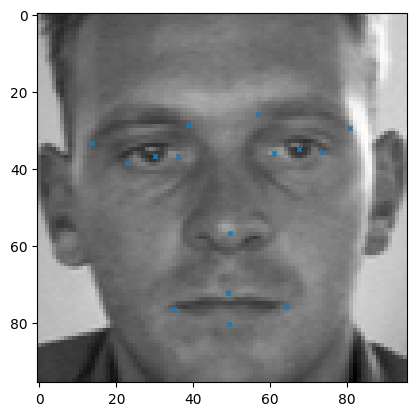

In [ ]:
# loading data

X, y = load()

print("\n Sample image with labels:")
plot_sample(X[13],y[13])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


### START OF MY SOLUTION

In [ ]:
from scipy.ndimage import gaussian_filter

num_images = x_train.shape[0]
num_augmentations = 6
augmented_images = np.ndarray(shape=(x_train.shape[0]*num_augmentations, x_train.shape[1], x_train.shape[2]))
augmented_targets = np.ndarray(shape=(y_train.shape[0]*num_augmentations, y_train.shape[1]))
columns = ["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y", "left_eye_inner_corner_x", "left_eye_inner_corner_y", "left_eye_outer_corner_x",
           "left_eye_outer_corner_y", "right_eye_inner_corner_x", "right_eye_inner_corner_y", "right_eye_outer_corner_x", "right_eye_outer_corner_y", "left_eyebrow_inner_end_x",
           "left_eyebrow_inner_end_y", "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y", "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y", "right_eyebrow_outer_end_x",
           "right_eyebrow_outer_end_y", "nose_tip_x", "nose_tip_y", "mouth_left_corner_x", "mouth_left_corner_y", "mouth_right_corner_x", "mouth_right_corner_y",
           "mouth_center_top_lip_x", "mouth_center_top_lip_y", "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]

flip_hor = np.array([(-1)**(i+1) for i in range(30)])
flip_ver = np.array([(-1)**(i) for i in range(30)])

# data augmentation
for i in range(num_images):
    image = np.squeeze(x_train[i, :, :])
    target = y_train[i, :]

    # original
    augmented_images[i, :, :] = image
    augmented_targets[i, :] = target

    # blurred
    augmented_images[i+num_images, :] = gaussian_filter(image, sigma=2)
    augmented_targets[i+num_images, :] = target

    # brighter
    augmented_images[i+num_images*2, :, :] = (image + 1)/2
    augmented_targets[i+num_images*2, :] = target

    # darker
    augmented_images[i+num_images*3, :, :] = image/2
    augmented_targets[i+num_images*3, :] = target

    # flipped horizontally
    augmented_images[i + num_images*4, :, :] = np.fliplr(image)
    aux_targets_flip = np.multiply(flip_hor, target)

    # flip labels
    left_indices_flip = [j for (j, el) in enumerate(columns) if 'left' in el]
    right_indices_flip = [j for (j, el) in enumerate(columns) if 'right' in el]
    aux_targets_flip[left_indices_flip], aux_targets_flip[right_indices_flip] = aux_targets_flip[right_indices_flip], aux_targets_flip[left_indices_flip]
    augmented_targets[i + num_images*4, :] = aux_targets_flip

    # data dropout (10% of 96x96, regularization technique)
    num_replaced_dropout = 922
    indices_x_dropout = np.random.randint(0, image.shape[0], num_replaced_dropout)
    indices_y_dropout = np.random.randint(0, image.shape[1], num_replaced_dropout)
    aux_image_dropout = np.copy(image)
    aux_image_dropout[indices_x_dropout, indices_y_dropout] = 0
    augmented_images[i + num_images*5, :, :] = aux_image_dropout
    augmented_targets[i + num_images*5, :] = target


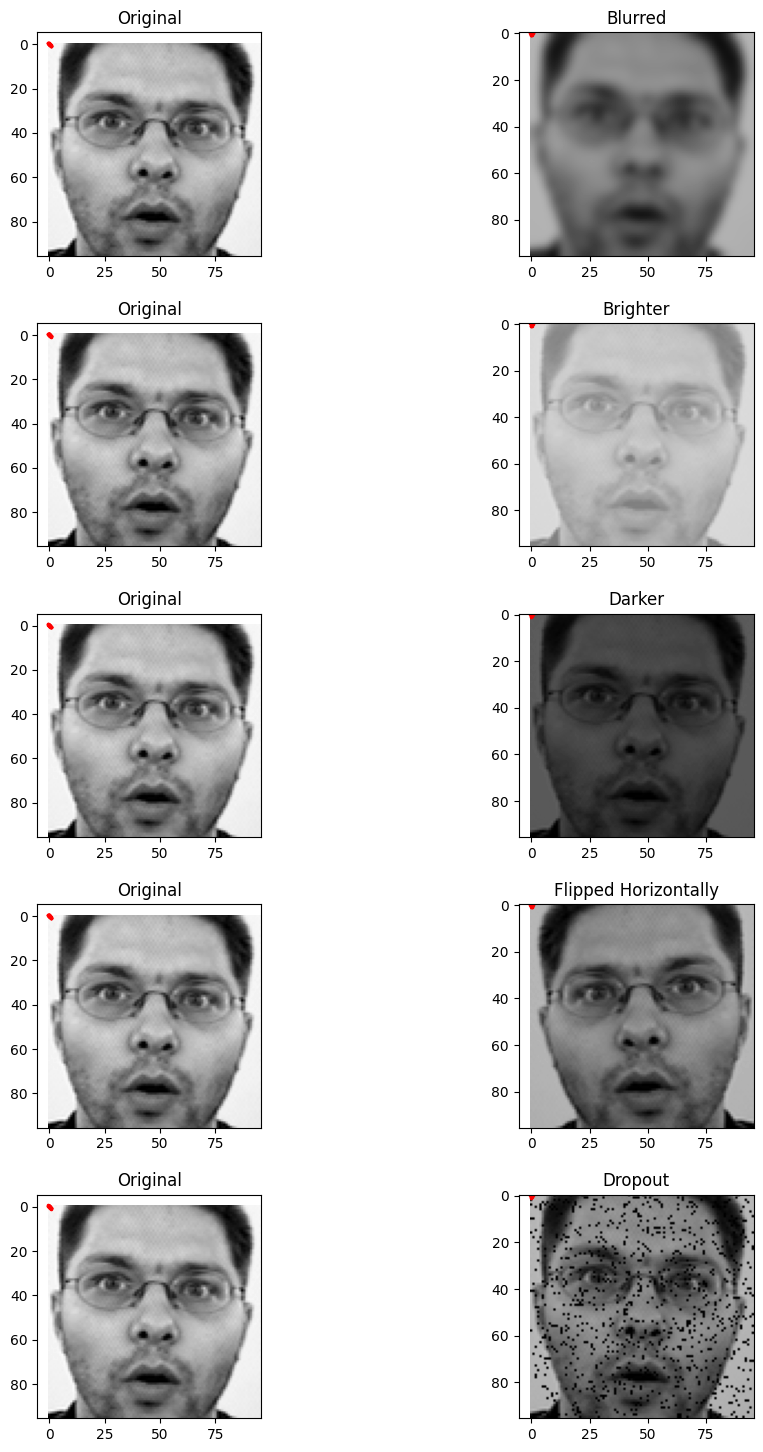

In [ ]:
import matplotlib.pyplot as plt

# 6x2 grid for plots
fig, axs = plt.subplots(5, 2, figsize=(12, 18), gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

# original in the first column for comparison
for i in range(5):
    axs[i, 0].imshow(augmented_images[12], cmap='gray')
    axs[i, 0].set_title("Original")
    axs[i, 0].scatter(augmented_targets[12], augmented_targets[12], s=10, marker='.', c='r')

# augmentation titles and corresponding indices
augmentation_titles = ["Blurred", "Brighter", "Darker", "Flipped Horizontally", "Dropout"]
augmentation_indices = [1, 2, 3, 4, 5]

# augmented images in the second column
for i, title, idx in zip(range(6), augmentation_titles, augmentation_indices):
    axs[i, 1].imshow(augmented_images[12 + num_images * idx], cmap='gray', vmin=0, vmax=1)
    axs[i, 1].set_title(title)
    axs[i, 1].scatter(augmented_targets[12 + num_images * idx][0::2], augmented_targets[12 + num_images * idx][1::2], s=10, marker='.', c='r')

plt.show()

In [ ]:
# repeat samples to have even more data for training
num_repeats = 3
augmented_images = np.concatenate([augmented_images] * num_repeats, axis=0)
augmented_targets = np.concatenate([augmented_targets] * num_repeats, axis=0)
augmented_images = np.expand_dims(augmented_images, -1)
print(augmented_images.shape)

(26964, 96, 96, 1)


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# parameters
input_shape = (96, 96, 1)
output_shape = 30

def create_model():
    return keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.BatchNormalization(),
            layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.GlobalAveragePooling2D(),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.50),
            layers.Dense(90, activation="relu"),
            layers.Dense(output_shape, activation="tanh"),
        ]
    )

model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 96, 96, 1)         4         
 chNormalization)                                                
                                                                 
 conv2d_30 (Conv2D)          (None, 96, 96, 16)        416       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 32)        12832     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                      

In [ ]:
from keras import backend as K
from keras.callbacks import EarlyStopping

batch_size = 32
epochs = 1000

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer='adam')

cb_list = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001, mode='auto')]
model.fit(augmented_images, augmented_targets, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=cb_list)

Epoch 1/1000
1349/1349 [==============================] - 457s 337ms/step - loss: 0.0677 - val_loss: 0.0577
Epoch 2/1000
1349/1349 [==============================] - 470s 349ms/step - loss: 0.0453 - val_loss: 0.0377
Epoch 3/1000
1349/1349 [==============================] - 438s 324ms/step - loss: 0.0350 - val_loss: 0.0295
Epoch 4/1000
1349/1349 [==============================] - 428s 318ms/step - loss: 0.0311 - val_loss: 0.0266
Epoch 5/1000
1349/1349 [==============================] - 430s 319ms/step - loss: 0.0292 - val_loss: 0.0246
Epoch 6/1000
1349/1349 [==============================] - 428s 317ms/step - loss: 0.0280 - val_loss: 0.0233
Epoch 7/1000
1349/1349 [==============================] - 431s 320ms/step - loss: 0.0271 - val_loss: 0.0226
Epoch 8/1000
1349/1349 [==============================] - 433s 321ms/step - loss: 0.0263 - val_loss: 0.0223
Epoch 9/1000
1349/1349 [==============================] - 429s 318ms/step - loss: 0.0256 - val_loss: 0.0206
Epoch 10/1000
1349/1349 [===

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 4ms/step
Mean pixel error:  1.3418007


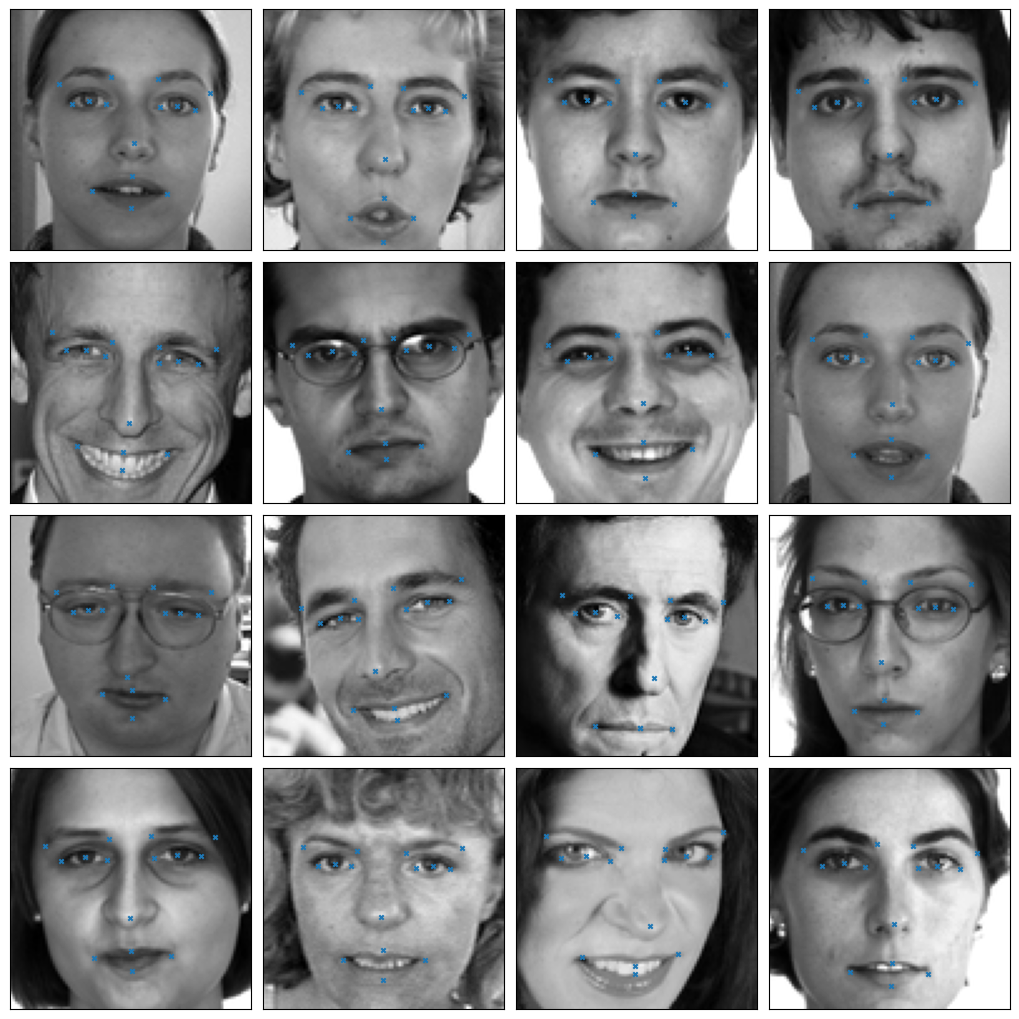

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

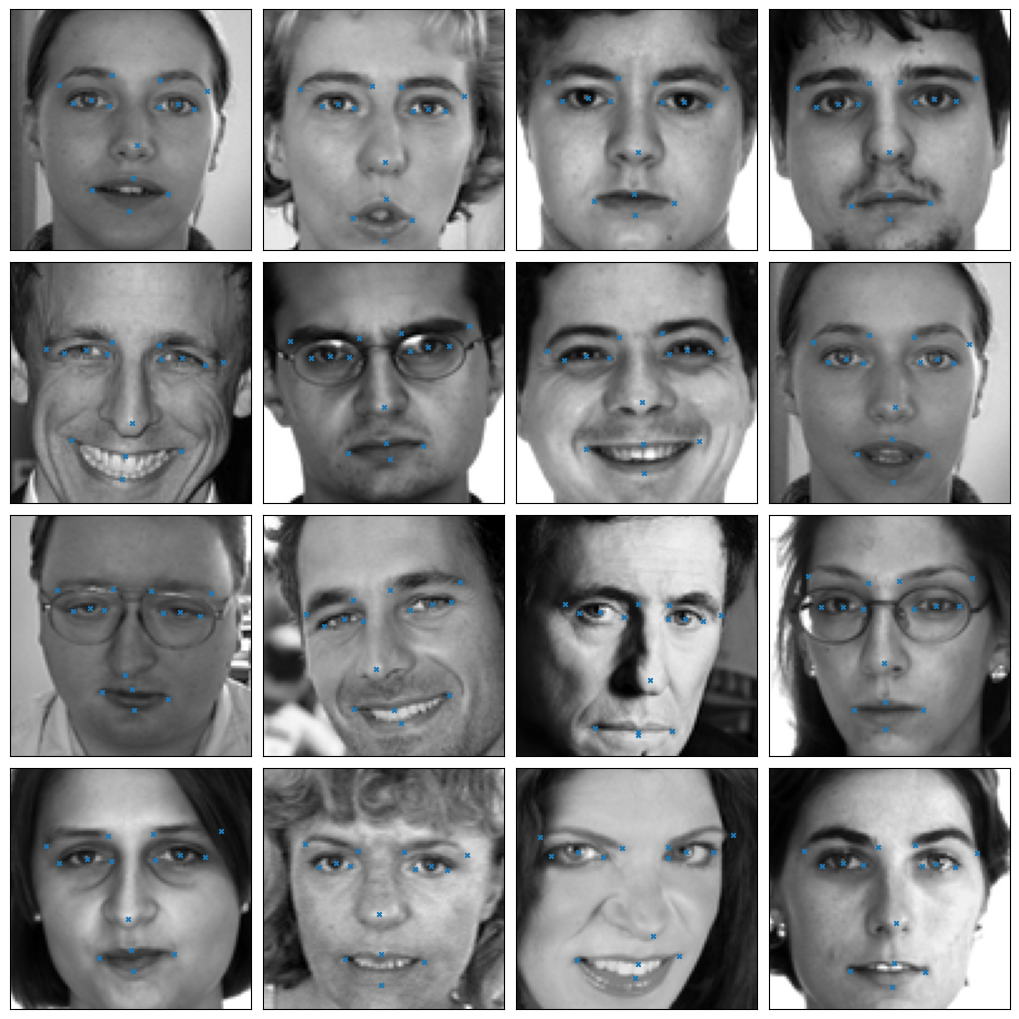

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

### END OF MY SOLUTION

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_3 (Dense)             (None, 30)               

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 3s 92ms/step - loss: 0.3150 - val_loss: 0.1994
Epoch 2/50
11/11 [==============================] - 0s 41ms/step - loss: 0.1381 - val_loss: 0.1099
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0922 - val_loss: 0.0833
Epoch 4/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0702 - val_loss: 0.0660
Epoch 5/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0634 - val_loss: 0.0646
Epoch 6/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0571 - val_loss: 0.0579
Epoch 7/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0506 - val_loss: 0.0517
Epoch 8/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0467 - val_loss: 0.0505
Epoch 9/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0419 - val_loss: 0.0449
Epoch 10/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0403 - val_loss: 0.0441
Epoch 11/

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 10ms/step
Mean pixel error:  1.9349903


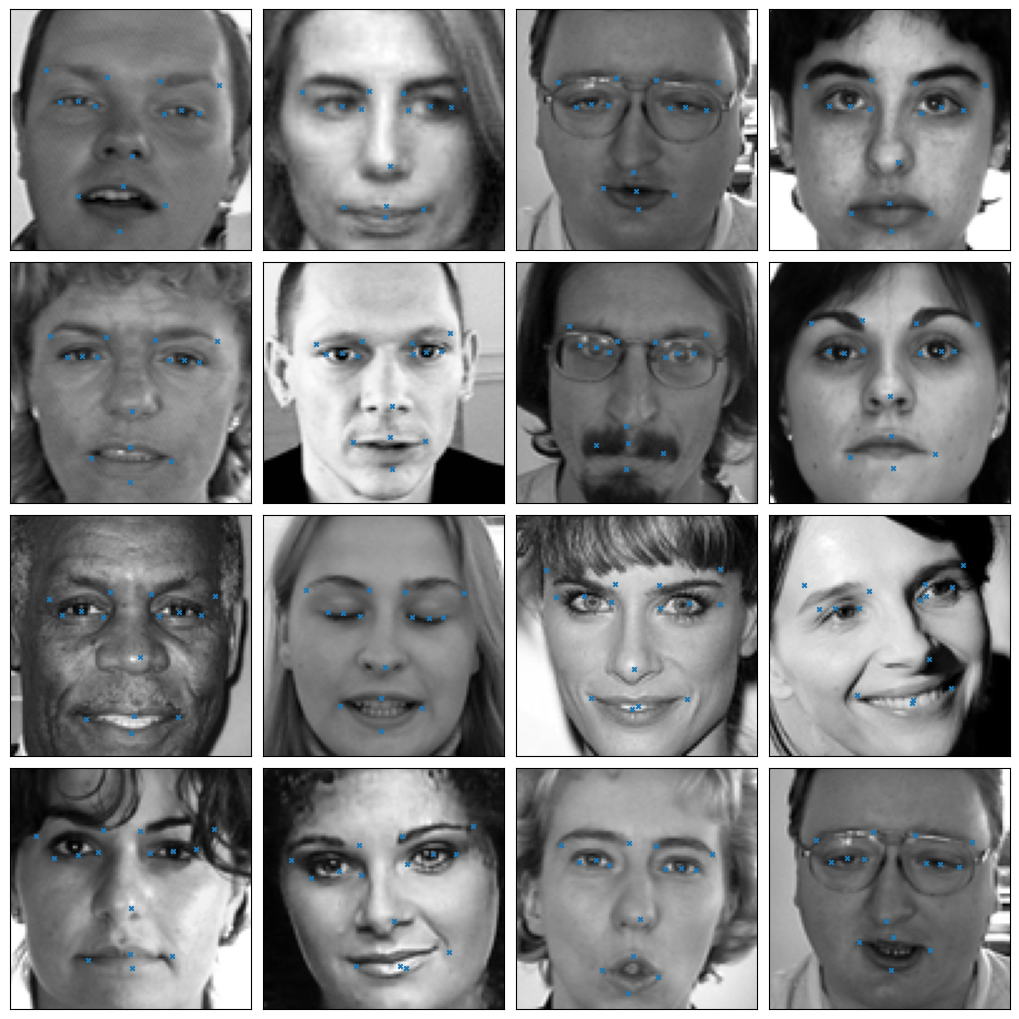

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

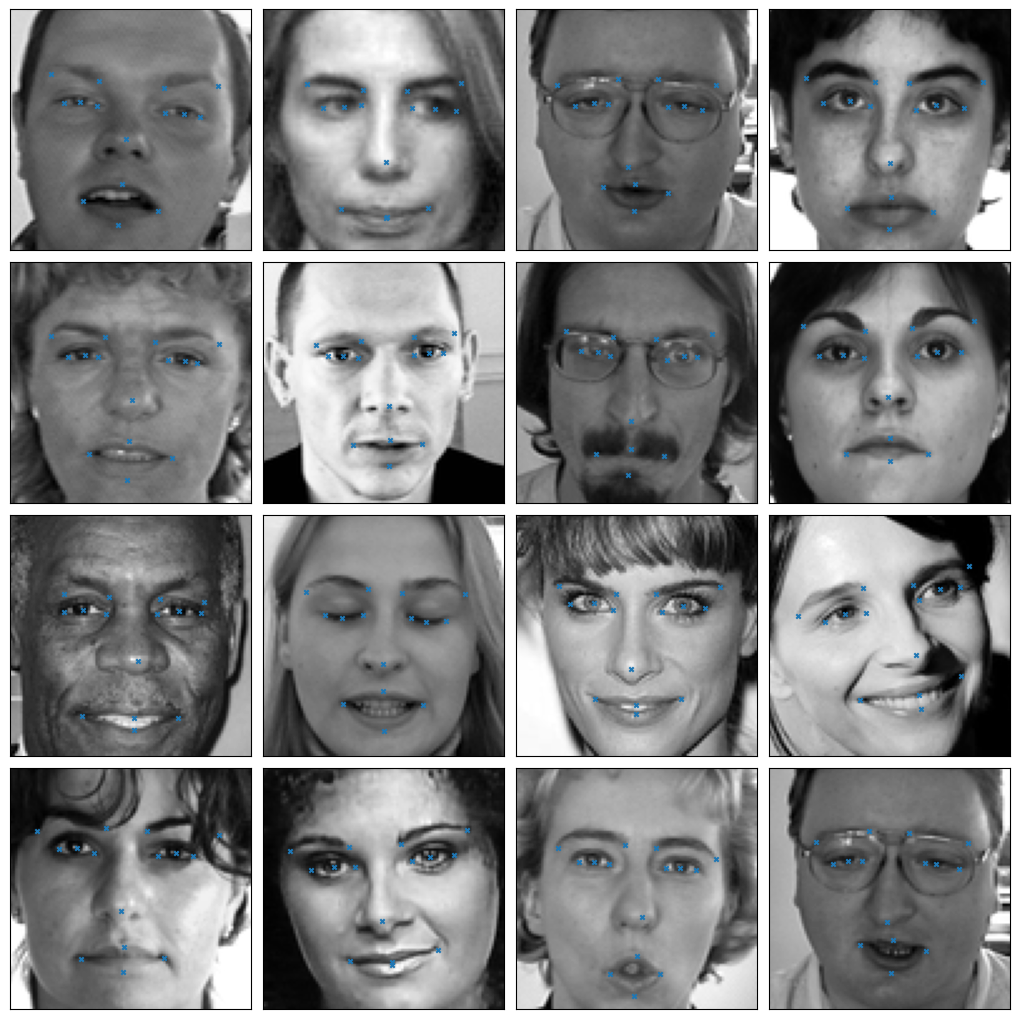

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.3 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.3418007.

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: My first step was the data augmentation. Immediately I knew that I wanted to perform a flipped horizontally, flipped vertically, blur, brighter, and darker. I was aware that I needed to flip the labels when I was performing my horizontal and vertical flips; however, I was still making a mistake for quite some time because I was performing the flipping of the lables before computing the blur, brighter, and darker augmentations. This caused the labels to be flipped for these computations as well. Eventually I went back and changed the order of augmentation to blur, brighter, darker, flipping horizontally, and flipping vertically. I then ran this with the simple model already defined and it did not cause nearly any improvement.

So, to begin improving the model, I first went to a model with 3 layers. I also immediately implemented early stopping so that I could test as many models as possible. At this point I still had the batch size relatively high as well to accomplish the same. Adding a third layer did not improve the model much, so I jumped up to a model with 5 layers. This improved the model a bit, so I decided to stick with this number of layers. I didn't think the data was complex enough to go much farther than that. I knew I wanted to keep my activation function as relu and the padding and pooling the same as well, but I did change the kernel size to be (5,5) for the first 3 layers. I also tried changing the optimizer, but adam ended up working better than SGD in the long run.

Now, I went back to try to improve the data. I realized that my model performed better when flipping vertically was removed, so I removed this augmentation. I also knew that having more data would benefit the model, so I decided to append the dataset to itself, so the model would have more data for training. Initially I only appended it once, but nothing much changed in my accuracy, so I then appended each dataset to itself twice, and this ended up making a difference. I also decided now to add dropout as a regularization technique. What I reaad online said that anywhere from 10-20% of dropout is normally used, so I tested 10%, 15%, and 20%. 10% improved the model the most, so I stuck with this.

Finally, I decided to improve my model as the last final push. I did some research and saw that batch normalization and global average pooling were commonly used in similar tasks, so I added this to my model. Finally, I added another dense layer at the end and a dropout layer between the two dense layers. I tried dropout proportions .20, .30, .40, and .50 after reading online this is an appropriate range, but .50 always worked best. Lastly, I played around with the batch size. It seemed that a larger batch size was behaving worse, so I went with a size of 16. I also checked 32 a few times, and this is what gave me the accuracy I acheived here.

